In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from HexClasses import HEX, Fluid, Fouling
from utils import get_Tf
from scipy.optimize import fsolve

### 1. Load data

In [2]:
# initialise HEX
hex = HEX(ri=0.3, ro=0.35, R=0.6, k=397, n=1)

# initialise fluids
fluid1 = Fluid(Cp=470, rho=3100)
fluid2 = Fluid(Cp=500, rho=1000)

# initialise fouling layers
depo1 = Fouling()
depo2 = Fouling()

In [3]:
# f_type: 0 - parallel, 1 - counter
f_type = 0

if f_type == 0:
    dfs = pd.read_csv("../../py_data/HEXPractice/parallel.csv", header=0)
elif f_type == 1:
    dfs = pd.read_csv("../../py_data/HEXPractice/counter.csv", header=0)

In [4]:
dfs.head()

,Day,F1m,F1i,F1o,F1v,F1D,F1Re,F1h,dP,Sigma1,...,F2i,F2o,F2v,F2D,F2Re,F2h,Sigma2,Rf2,UA,Q
0,1,6.165044,274.096089,295.923870,0.007034,0.6,13082.629695,44.960444,0.012247,0.000000e+00,...,620.025757,601.581740,0.009192,0.5,4595.943163,23.949937,0.0,0.0,1.945018,63247.540711
1,2,7.355776,274.534244,288.706959,0.008392,0.6,15609.442452,51.782679,0.017281,3.241448e-08,...,601.449694,578.843042,0.005810,0.5,2904.889680,16.592368,0.0,0.0,1.590971,48998.116374
2,3,7.195550,274.786601,293.607169,0.008209,0.6,15269.433722,50.878343,0.016554,4.058205e-08,...,615.128064,595.648472,0.008759,0.5,4379.265332,23.042291,0.0,0.0,1.985205,63649.440587
3,4,4.123915,282.080236,308.130725,0.004705,0.6,8751.220861,32.593392,0.005604,6.040530e-08,...,602.070703,587.165857,0.009081,0.5,4540.278087,23.717593,0.0,0.0,1.689599,50492.100345
4,5,7.242164,302.004015,318.354824,0.008263,0.6,15368.356112,51.141882,0.016764,1.507969e-07,...,608.898284,590.777980,0.008233,0.5,4116.484370,21.929354,0.0,0.0,1.924824,55655.157976


Suppose we only have monitoring data of inlet temeratures:
$T_{1, \text{in}}, T_{2, \text{in}}$,
and mass flow rates:
$\dot{m}_{1}, \dot{m}_{2}$.

In [5]:
T1i = dfs["F1i"]       # Fluid1 (cold) inlet temperature
m1 = dfs["F1m"]       # Fluid1 (cold) mass flow rate
T2i = dfs["F2i"]      # Fluid2 (hot) inlet temperature
m2 = dfs["F2m"]     # Fluid2 (hot) mass flow rate

In [6]:
# dataframe for recording data
df2 = pd.DataFrame()
Day = []
UAs = []
T1in = []
T1m = []
T1o = []
T1v = []
T1D = []
T1Re = []
T1Pr = []
T1h = []
T1pd = []
Sigma1 = []
Rf1 =[]
T2in = []
T2m = []
T2o = []
T2v = []
T2D = []
T2Re = []
T2Pr = []
T2h = []
Sigma2 = []
Rf2 =[]
Q = []

def append_Vars(day, uas, 
                t1i, t1m, t1v, t1d, t1re, t1h, t1pd, sigma1, rf1,
                t2i, t2m, t2v, t2d, t2re, t2h, sigma2, rf2):
    Day.append(day)
    UAs.append(uas)
    T1in.append(t1i)
    T1m.append(t1m)
    T1v.append(t1v)
    T1D.append(t1d)
    T1Re.append(t1re)
    T1h.append(t1h)
    T1pd.append(t1pd)
    Sigma1.append(sigma1)
    Rf1.append(rf1)
    T2in.append(t2i)
    T2m.append(t2m)
    T2v.append(t2v)
    T2D.append(t2d)
    T2Re.append(t2re)
    T2h.append(t2h)
    Sigma2.append(sigma2)
    Rf2.append(rf2)

### 2. Start simulation

In [7]:
for day in range(len(dfs)):
    t1i = T1i[day]
    t2i = T2i[day]
    m1i = m1[day]
    m2i = m2[day]

    fluid1.get_Inlets(t1i, m1i)
    fluid2.get_Inlets(t2i, m2i)

    fluid1.get_Prams(hex.Ac1, hex.D1, hex.As1)
    fluid2.get_Prams(hex.Ac2, hex.D2, hex.As2)
    UA = 1 / (fluid1.R + hex.Rfi + hex.dRwall + hex.Rfo + fluid2.R)       # W*m^2/n^2*k Overall heat transfer coefficient times surface area (1 / Total Resistance)
    dPdx = fluid1.get_PressureDrop(fluid1.Cf, fluid1.v, hex.rfi)

    append_Vars(day + 1, UA, 
            t1i, m1i, fluid1.v, hex.D1, fluid1.Re, fluid1.h, dPdx * hex.dx, depo1.sigma, hex.Rfi,
            t2i, m2i, fluid2.v, hex.D2, fluid2.Re, fluid2.h, depo2.sigma, hex.Rfo)

    '''
    Function for solving outlets
    '''
    def Solve_outlets(sol):
        if f_type == 0:
            dT1 = t2i - t1i
            dT2 = sol[1] - sol[0]
        elif f_type == 1:
            dT1 = t2i - sol[0]
            dT2 = sol[1] - t1i
        dTlm = (dT1 - dT2) / np.log(dT1 / dT2)

        dQdt = m1i * fluid1.Cp * (sol[0] - t1i)
        return [dQdt - m2i * fluid2.Cp * (t2i - sol[1]),  dQdt - 0.99937 * UA * dTlm]
    
    # sol = fsolve(Solve_outlets, [t1i + 5, t2i - 5])
    # guess with the true values
    sol = fsolve(Solve_outlets, [dfs["F1o"][day], dfs["F2o"][day]]) 
    t1o = sol[0]
    t2o = sol[1]

    # heat duty and film temperature
    dQdt = m1i * fluid1.Cp * np.abs(t1i - t1o)
    Tf1, Tf2 = get_Tf(dQdt, np.mean([t1i, t1o]), np.mean([t2i, t2o]), fluid1.R, fluid2.R)

    # simulate fouling thickness for the next day
    depo1.FoulingSimu(fluid1.Re, fluid1.Pr, Tf1, fluid1.tau, depo1.k_l0, 24 * 3600)
    # depo2.FoulingSimu(fluid2.Re, fluid2.Pr, Tf2, fluid2.tau, depo2.k_l0, 24 * 3600)

    # update HEX parameters
    hex.update_Prams(depo1.sigma, depo2.sigma, depo1.k_l0, depo2.k_l0)

    # append the rest variables
    T1o.append(t1o)
    T2o.append(t2o)
    Q.append(np.sum(dQdt))

Store data frame

In [8]:
df2["Day"] = Day
df2["F1m"] = T1m
df2["F1i"] = T1in
df2["F1o"] = T1o
df2["F1v"] = T1v
df2["F1D"] = T1D
df2["F1Re"] = T1Re
df2["F1h"] = T1h
df2["dP"] = T1pd
df2["Sigma1"] = Sigma1
df2["Rf1"] = Rf1
df2["F2m"] = T2m
df2["F2i"] = T2in
df2["F2o"] = T2o
df2["F2v"] = T2v
df2["F2D"] = T2D
df2["F2Re"] = T2Re
df2["F2h"] = T2h
df2["Sigma2"] = Sigma2
df2["Rf2"] = Rf2
df2["UA"] = UAs
df2["Q"] = Q

if f_type == 0:
    df2.to_csv("../../py_data/HEXPractice/parallel_lumped.csv", index=False)
else:
    df2.to_csv("../../py_data/HEXPractice/counter_lumped.csv", index=False)

### 2. Compare result with distributed one

In [9]:
if f_type == 0:
    df2 = pd.read_csv("../../py_data/HEXPractice/parallel_lumped.csv", header=0)
elif f_type == 1:
    df2 = pd.read_csv("../../py_data/HEXPractice/counter_lumped.csv", header=0)

In [10]:
# dfs: distributed, df2: lumped
np.sum(np.abs(dfs - df2))

Day       0.000000e+00
F1m       0.000000e+00
F1i       0.000000e+00
F1o       9.370001e-02
F1v       1.275988e-06
F1D       5.540521e-05
F1Re      1.186628e+00
F1h       7.344141e-03
dP        5.597047e-06
Sigma1    2.770260e-05
Rf1       4.317045e-02
F2m       0.000000e+00
F2i       0.000000e+00
F2o       8.306534e-02
F2v       1.994932e-16
F2D       0.000000e+00
F2Re      1.559783e-10
F2h       8.508749e-13
Sigma2    0.000000e+00
Rf2       0.000000e+00
UA        3.533089e+04
Q         2.452760e+02
dtype: float64

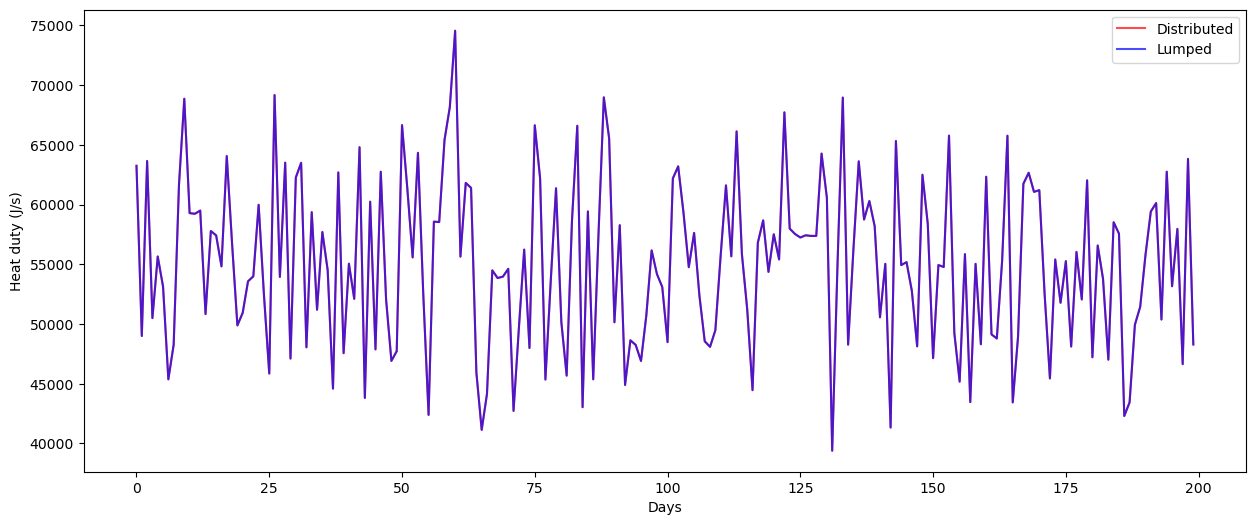

In [11]:
# Heat duty vs. time
plt.figure(figsize=(15, 6))
plt.plot(dfs["Q"].to_numpy(), c="r", alpha=0.7, label="Distributed")
plt.plot(df2["Q"].to_numpy(), c="b", alpha=0.7, label="Lumped")
plt.ylabel("Heat duty (J/s)")
plt.xlabel("Days")
plt.legend()
plt.show()

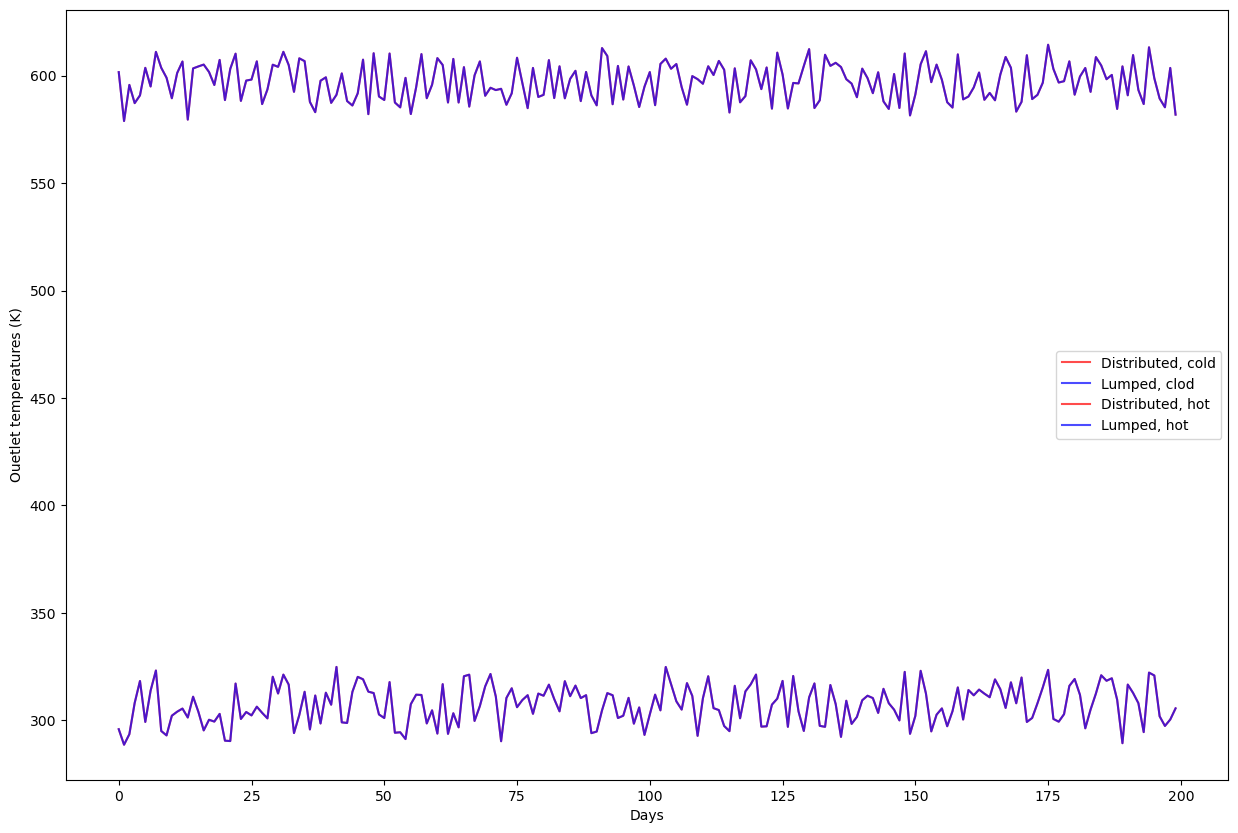

In [12]:
# Outlet temperature vs. time
plt.figure(figsize=(15, 10))
plt.plot(dfs["F1o"].to_numpy(), c="r", alpha=0.7, label="Distributed, cold")
plt.plot(df2["F1o"].to_numpy(), c="b", alpha=0.7, label="Lumped, clod")

plt.plot(dfs["F2o"].to_numpy(), c="r", alpha=0.7, label="Distributed, hot")
plt.plot(df2["F2o"].to_numpy(), c="b", alpha=0.7, label="Lumped, hot")
plt.ylabel("Ouetlet temperatures (K)")
plt.xlabel("Days")
plt.legend()
plt.show()

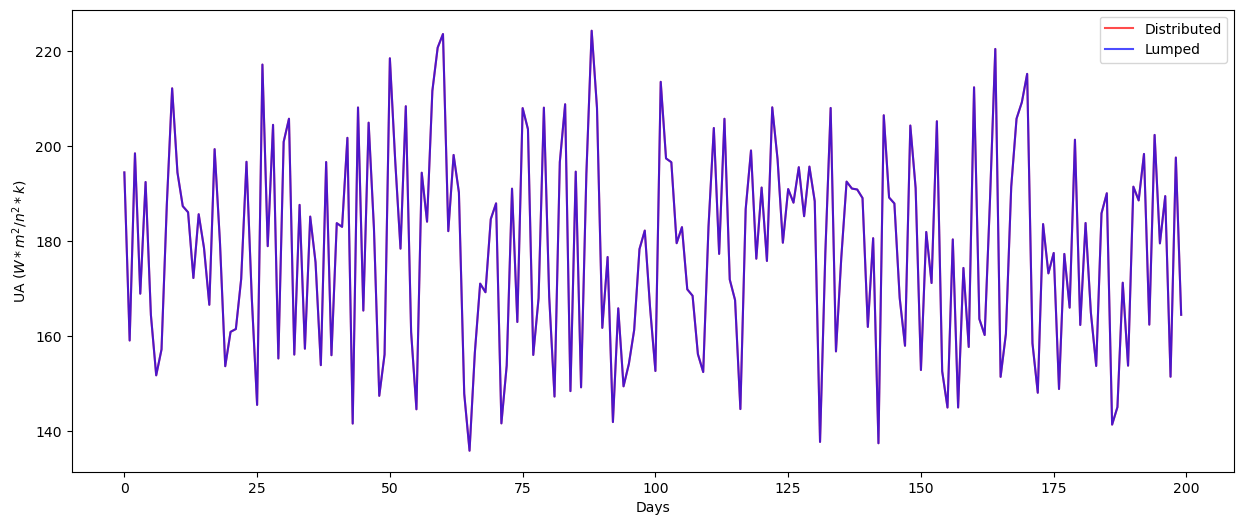

In [13]:
# UA vs. time, lumped should be about 100 times
plt.figure(figsize=(15, 6))
plt.plot(dfs["UA"] * 100, c="r", alpha=0.7, label="Distributed")
plt.plot(df2["UA"], c="b", alpha=0.7, label="Lumped")
plt.ylabel("UA ($W*m^2/n^2*k$)")
plt.xlabel("Days")
plt.legend()
plt.show()

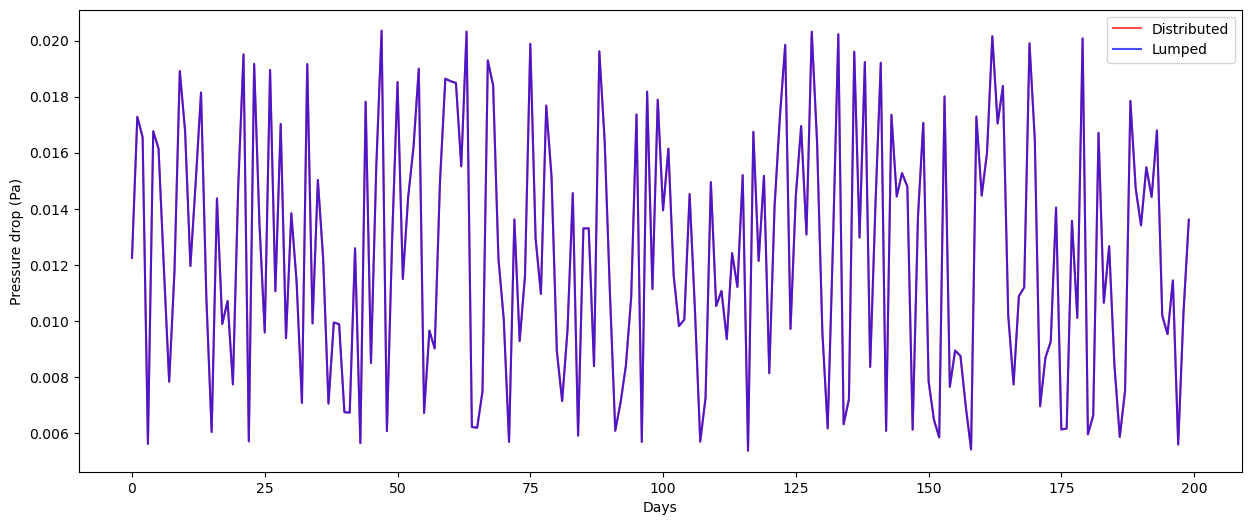

In [14]:
# dP vs. time
plt.figure(figsize=(15, 6))
plt.plot(dfs["dP"], c="r", alpha=0.7, label="Distributed")
plt.plot(df2["dP"], c="b", alpha=0.7, label="Lumped")
plt.ylabel("Pressure drop (Pa)")
plt.xlabel("Days")
plt.legend()
plt.show()

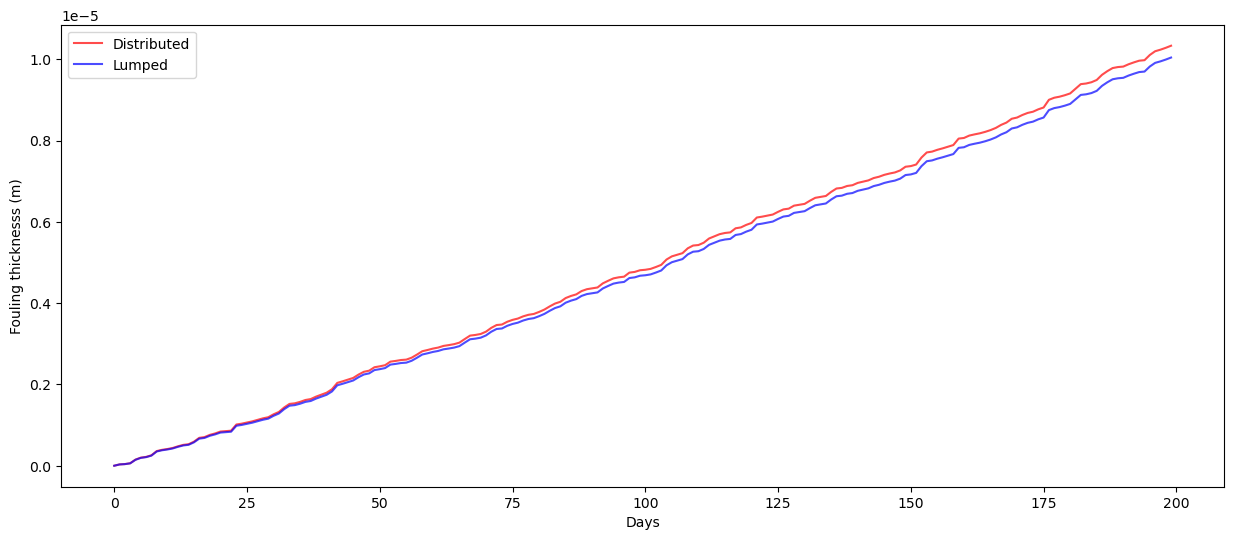

In [15]:
# Fouling thickness vs. time
plt.figure(figsize=(15, 6))
plt.plot(dfs["Sigma1"], c="r", alpha=0.7, label="Distributed")
plt.plot(df2["Sigma1"], c="b", alpha=0.7, label="Lumped")
plt.ylabel("Fouling thicknesss (m)")
plt.xlabel("Days")
plt.legend()
plt.show()